# Fraud in Electricity and Gas Consumption #

## Data Cleaning

### Since 2 datasets were provided, we attempt to combine both datasets into 1 on the id columm. ###

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import spearmanr
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

seed = 69


In [55]:
invoice_df = pd.read_csv('invoice.csv')
client_df = pd.read_csv('client.csv')

combined_df = pd.merge(client_df, invoice_df, on='id', how='left')



In [56]:
combined_df.head()

,region,date_x,dis,id,catg,target,date_y,tarif_type,counter_number,counter_statue,...,reading_remarque,consommation_level_4,old_index,new_index,months_number,counter_type,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3
0,101,31/12/1994,60,train_Client_0,11,0,24/3/2014,11,1335667.0,0,...,8,0,14302,14384,4,ELEC,1,82,0,0
1,101,31/12/1994,60,train_Client_0,11,0,29/3/2013,11,1335667.0,0,...,6,0,12294,13678,4,ELEC,1,1200,184,0
2,101,31/12/1994,60,train_Client_0,11,0,23/3/2015,11,1335667.0,0,...,8,0,14624,14747,4,ELEC,1,123,0,0
3,101,31/12/1994,60,train_Client_0,11,0,13/7/2015,11,1335667.0,0,...,8,0,14747,14849,4,ELEC,1,102,0,0
4,101,31/12/1994,60,train_Client_0,11,0,17/11/2016,11,1335667.0,0,...,9,0,15066,15638,12,ELEC,1,572,0,0


In [57]:
combined_df.describe()


,region,dis,catg,target,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,consommation_level_4,old_index,new_index,months_number,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3
count,500651.000000,500651.000000,500651.000000,500651.000000,500651.000000,5.006510e+05,500651.000000,500651.000000,500651.000000,500651.000000,5.006510e+05,5.006510e+05,500651.000000,500651.000000,500651.000000,500651.000000,500651.000000
mean,204.746922,63.519156,11.353871,0.062644,16.108279,1.951034e+11,0.050217,204.390755,7.463710,64.393150,1.575969e+04,1.639037e+04,22.744289,1.000154,443.065463,120.508706,28.196772
std,104.620488,3.388720,3.661420,0.242323,11.145881,2.071552e+12,0.396153,121.204514,1.374409,1230.465569,2.975733e+04,3.053707e+04,1670.624818,0.047150,592.249623,1396.817086,214.020756
min,101.000000,60.000000,11.000000,0.000000,9.000000,0.000000e+00,0.000000,5.000000,6.000000,0.000000,0.000000e+00,0.000000e+00,1.000000,1.000000,0.000000,0.000000,0.000000
25%,101.000000,62.000000,11.000000,0.000000,11.000000,1.477220e+05,0.000000,202.000000,6.000000,0.000000,1.799000e+03,2.165000e+03,4.000000,1.000000,99.000000,0.000000,0.000000
50%,107.000000,62.000000,11.000000,0.000000,11.000000,4.857010e+05,0.000000,203.000000,8.000000,0.000000,7.876000e+03,8.438000e+03,4.000000,1.000000,321.000000,0.000000,0.000000
75%,307.000000,69.000000,11.000000,0.000000,11.000000,1.008740e+06,0.000000,207.000000,9.000000,0.000000,2.092750e+04,2.164500e+04,4.000000,1.000000,661.000000,0.000000,0.000000
max,399.000000,69.000000,51.000000,1.000000,45.000000,2.740000e+13,5.000000,600.000000,9.000000,343568.000000,2.800280e+06,2.870972e+06,231602.000000,20.000000,98889.000000,819886.000000,45360.000000


In [58]:
print(f"Length of dataset: {len(combined_df)}")


print(f"Number of datapoints in each column: \n{combined_df.count()} \n")

Length of dataset: 500651
Number of datapoints in each column: 
region                  500651
date_x                  500651
dis                     500651
id                      500651
catg                    500651
target                  500651
date_y                  500651
tarif_type              500651
counter_number          500651
counter_statue          500651
counter_code            500651
reading_remarque        500651
consommation_level_4    500651
old_index               500651
new_index               500651
months_number           500651
counter_type            500651
counter_coefficient     500651
consommation_level_1    500651
consommation_level_2    500651
consommation_level_3    500651
dtype: int64 



In [59]:
number_of_fraud = sum(combined_df["target"] == 1)
print(number_of_fraud)
print(f"proportion of fraud: {number_of_fraud/len(combined_df)}")

31363
proportion of fraud: 0.06264443694310008


#### We have created 4 new variables, described as such:
##### delta_start_invoice: diff between join and transaction date
##### delta_index: diff between old and new index
##### delta_transactions: diff between transactions over the same client
##### consommation_sum: sum of consommation levels

In [60]:
dates = {'join_date': combined_df['date_x'], 'transaction_date': combined_df['date_y'], 'id': combined_df['id']}
dates_df = pd.DataFrame(dates)

# Assuming 'date_x' and 'date_y' are in 'combined_df'
combined_df['date_x'] = pd.to_datetime(combined_df['date_x'], format='%d/%m/%Y')
combined_df['date_y'] = pd.to_datetime(combined_df['date_y'], format='%d/%m/%Y')

# Calculate the difference in days between 'date_y' and 'date_x'
dates_df['delta_start_invoice'] = (combined_df['date_y'] - combined_df['date_x']).dt.days

# Create new delta_transactions (diff between transaction dates for each client)
dates_df = dates_df.sort_values(['id', 'delta_start_invoice'])
dates_df['delta_transactions'] = dates_df.groupby('id')['delta_start_invoice'].diff().fillna(0)
# Display the first few rows of the DataFrame
dates_df.head()




,join_date,transaction_date,id,delta_start_invoice,delta_transactions
22,31/12/1994,17/10/2005,train_Client_0,3943,0.0
23,31/12/1994,24/2/2006,train_Client_0,4073,130.0
24,31/12/1994,23/6/2006,train_Client_0,4192,119.0
25,31/12/1994,18/10/2006,train_Client_0,4309,117.0
28,31/12/1994,26/2/2007,train_Client_0,4440,131.0


#### add new delta_start_invoice, delta_index and consommation_sum to combined_df

In [61]:
combined_df['delta_index'] = combined_df['new_index'] - combined_df['old_index']
combined_df['delta_start_invoice'] = dates_df['delta_start_invoice']
combined_df['consommation_sum'] = sum([combined_df['consommation_level_1'], combined_df['consommation_level_2'], combined_df['consommation_level_3'], combined_df['consommation_level_4']])
combined_df['delta_transactions'] = dates_df['delta_transactions']

#### new dataframe for one-hot encoding categorical variables (dis, catg, region, tarif_type, counter_statue, counter_code, reading_remarque, counter_type)

In [62]:
categorical_vars = ['dis', 'catg', 'region', 'tarif_type', 'counter_statue', 'counter_code', 'reading_remarque', 'counter_type']
categorical_df = pd.get_dummies(combined_df, columns=categorical_vars, prefix=categorical_vars)
categorical_df = categorical_df.groupby('id').agg({col: 'max' for col in categorical_df.columns if col != 'id'})



#### Agg function to group the transactions with each client

In [63]:
stats = ['sum', 'mean', 'median', 'std']

selected_columns = ['consommation_level_1', 
                    'consommation_level_2', 'consommation_level_3', 'consommation_level_4',
                    'consommation_sum', 'delta_index', 'delta_start_invoice', 'id']

# Create a new dataframe with the desired aggregate functions
numerical_df = combined_df[selected_columns].groupby('id').agg(stats)

numerical_df.head()




consommation_level_1                                 \
                                   sum        mean median         std   
id                                                                      
train_Client_0                   12334  352.400000  267.0  310.343472   
train_Client_1                   20629  557.540541  520.0  197.935960   
train_Client_10                  14375  798.611111  655.5  513.841374   
train_Client_100                    24    1.200000    0.0    3.607011   
train_Client_1000                 9292  663.714286  770.0  224.831365   

                  consommation_level_2                                 \
                                   sum        mean median         std   
id                                                                      
train_Client_0                     370   10.571429    0.0   43.568935   
train_Client_1                       0    0.000000    0.0    0.000000   
train_Client_10                    682   37.888889    0.0  160.748942   
train_Client_100                     0    0.000000    0.0    0.000000   
train_Client_1000                 1468  104.857143    0.0  167.155320   

                  consommation_level_3              ... consommation_sum  \
                                   sum        mean  ...           median   
id                                                  ...                    
train_Client_0                       0    0.000000  ...            267.0   
train_Client_1                       0    0.000000  ...            520.0   
train_Client_10                      0    0.000000  ...            655.5   
train_Client_100                     0    0.000000  ...              0.0   
train_Client_1000                 1643  117.357143  ...            770.0   

                              delta_index                                 \
                          std         sum        mean median         std   
id                                                                         
train_Client_0     341.553930       12704  362.971429  267.0  341.553930   
train_Client_1     197.935960       20629  557.540541  520.0  197.935960   
train_Client_10    646.808386       15057  836.500000  655.5  646.808386   
train_Client_100     3.607011          24    1.200000    0.0    3.607011   
train_Client_1000  633.485669       12917  922.642857  770.0  633.485669   

                  delta_start_invoice                                    
                                  sum         mean  median          std  
id                                                                       
train_Client_0                 213142  6089.771429  6047.0  1358.574709  
train_Client_1                 132603  3583.864865  3509.0  1457.748762  
train_Client_10                165982  9221.222222  8678.0  1526.789733  
train_Client_100                91275  4563.750000  4545.5   774.520692  
train_Client_1000               13497   964.071429  1010.0   506.611437  

[5 rows x 28 columns]

#### Combining numerical and cat dataframes

In [64]:
to_drop = ['region', 'date_x', 'dis', 'id', 'catg', 'target', 'date_y', 'tarif_type', 'counter_number', 
           'counter_statue', 'counter_code', 'reading_remarque', 'consommation_level_4', 'old_index',
           'new_index', 'months_number', 'counter_type', 'counter_coefficient', 'consommation_level_1',
           'consommation_level_2', 'consommation_level_3']

client_summary = pd.concat([numerical_df, categorical_df], axis=1)

# Identify existing columns in the DataFrame
existing_columns = [col for col in to_drop if col in client_summary.columns]

# Drop existing columns from the DataFrame
client_summary = client_summary.drop(columns=existing_columns)

client_summary.info()




<class 'pandas.core.frame.DataFrame'>
Index: 21652 entries, train_Client_0 to train_Client_128438
Columns: 121 entries, ('consommation_level_1', 'sum') to counter_type_GAZ
dtypes: bool(89), float64(22), int64(10)
memory usage: 7.3+ MB


#### Add y variable

In [65]:
client_summary['target'] = combined_df.groupby('id')['target'].apply(lambda x: 1 if x.any() else 0)
client_summary['target'].value_counts()


target
0    20576
1     1076
Name: count, dtype: int64

In [66]:
combined_df.groupby('id')['target'].apply(lambda x: 1 if x.any() else 0).value_counts()

target
0    20576
1     1076
Name: count, dtype: int64

## Data Balancing

#### Due to the low proportion of fraud cases, we performed synthetic oversampling of fraud cases with SMOTE and undersampled non-fraud cases with Tomek's link 

In [67]:
# Define the oversampling strategy using SMOTE
smote = SMOTE(sampling_strategy='auto')

smote = SMOTE(random_state=seed)
tomek = TomekLinks()

X = client_summary.drop('target', axis=1)

# Flatten multi-level column names
X.columns = [''.join(map(str, col)).strip() for col in X.columns.to_flat_index()]

y = client_summary['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= seed)

# under and oversampling of data using Tomek and SMOTE
X_train, y_train = tomek.fit_resample(X_train, y_train)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


# Standardize the data separately to prevent leakage
scaler = StandardScaler()
X_train_standardized = pd.DataFrame(scaler.fit_transform(X_train_resampled), columns=X_train_resampled.columns)
X_test_standardized = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)



In [68]:
y_test.value_counts()


target
0    4115
1     216
Name: count, dtype: int64

In [69]:
y_train_resampled.value_counts()

target
0    16096
1    16096
Name: count, dtype: int64

In [70]:
# Change Bool to int
X_train_resampled = X_train_resampled.astype({col: int for col in X_train_resampled.select_dtypes(include='bool').columns})




In [71]:
corr_matrix = X_train_standardized.corrwith(y_train_resampled, method='spearman')

top_20_vars = corr_matrix.abs().sort_values(ascending=False).head(20).index.tolist()

print(top_20_vars)

['consommation_level_3sum', 'consommation_level_3mean', 'consommation_level_3std', 'consommation_level_2sum', 'reading_remarque_8', 'consommation_level_2std', 'consommation_level_4sum', 'consommation_level_2mean', 'consommation_sumsum', 'consommation_level_4std', 'consommation_level_4mean', 'delta_index', 'consommation_sum', 'delta_indexsum', 'delta_indexstd', 'consommation_sumstd', 'dis_69', 'consommation_level_1sum', 'reading_remarque_9', 'delta_start_invoicestd']


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [72]:
X_train_standardized_resampled_important = X_train_standardized[top_20_vars]
X_test_standardized_important = X_test_standardized[top_20_vars]

### Run Logistic Regression

In [73]:
print(f"Training dataset shape: {X_train_standardized_resampled_important.shape}")
print(f"Test dataset shape: {X_test_standardized_important.shape}")


Training dataset shape: (32192, 20)
Test dataset shape: (4331, 20)


In [74]:
model_LR = LogisticRegression()
model_LR.fit(X_train_standardized_resampled_important, y_train_resampled)

y_pred = model_LR.predict(X_test_standardized_important)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)
 
print(f"Precision = {precision}")
print(f"Recall = {recall}")
print(f"F1 Score = {f1score}")



Precision = 0.08760951188986232
Recall = 0.6481481481481481
F1 Score = 0.1543550165380375


In [75]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[2657, 1458],
       [  76,  140]], dtype=int64)

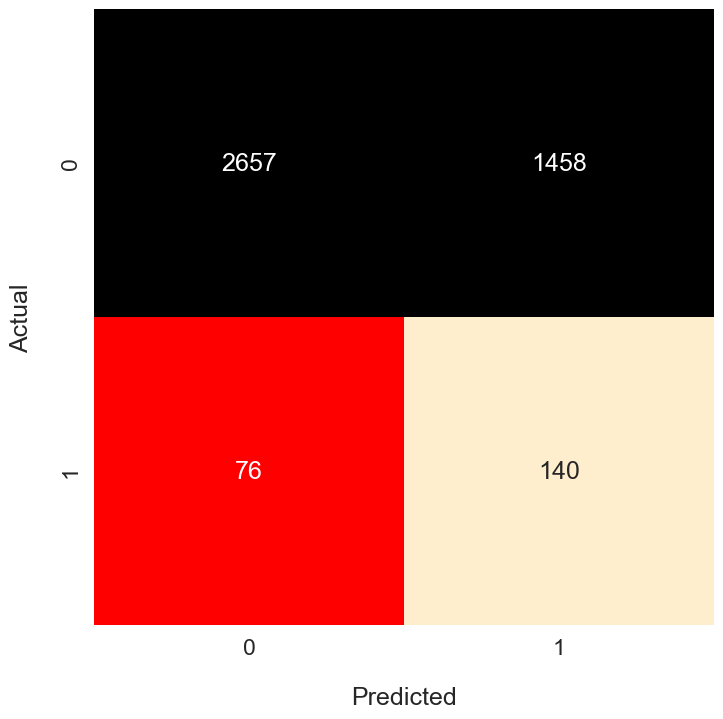

In [76]:
plt.figure(figsize=(8,8))
sns.set(font_scale = 1.5)
 
ax = sns.heatmap(
    conf_matrix, # confusion matrix 2D array 
    annot=True, # show numbers in the cells
    fmt='d', # show numbers as integers
    cbar=False, # don't show the color bar
    cmap='flag', # customize color map
    vmax=175 # to get better color contrast
)
 
ax.set_xlabel("Predicted", labelpad=20)
ax.set_ylabel("Actual", labelpad=20)
plt.show()